In [35]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from statistics import mean

# Merge tables

In [3]:
Date_type = ["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", 
             "order_delivered_customer_date", "order_estimated_delivery_date"]
customers = pd.read_csv('olist_customers_dataset.csv')
#geo = pd.read_csv('olist_geolocation_dataset.csv')
item = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
#review = pd.read_csv('olist_order_reviews_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv',parse_dates= Date_type)
seller = pd.read_csv('olist_sellers_dataset.csv')
product = pd.read_csv('olist_products_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

product_eng = pd.merge(product, translation, on="product_category_name").drop("product_category_name", axis = 1)
product_eng.insert(1, "product_category_name_english", product_eng.pop("product_category_name_english"))

#DataList = [customers, geo, item, payments, order, seller, product_eng]
#for i in DataList:
    #print (i.isnull().sum())
olist = pd.merge(pd.merge(pd.merge(item, payments, on = "order_id"),
                            order, on = "order_id"), 
                 product_eng, on = "product_id")
olist = pd.merge(pd.merge(olist, customers, on = "customer_id"), seller, on = "seller_id")
#olist.to_csv('olist.csv', index = None)

In [4]:
olist.order_status.unique()

array(['delivered', 'shipped', 'invoiced', 'canceled', 'processing',
       'unavailable', 'approved'], dtype=object)

In [5]:
#olist = pd.read_csv('olist.csv')
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   order_item_id                  115878 non-null  int64         
 2   product_id                     115878 non-null  object        
 3   seller_id                      115878 non-null  object        
 4   shipping_limit_date            115878 non-null  object        
 5   price                          115878 non-null  float64       
 6   freight_value                  115878 non-null  float64       
 7   payment_sequential             115878 non-null  int64         
 8   payment_type                   115878 non-null  object        
 9   payment_installments           115878 non-null  int64         
 10  payment_value                  115878 non-null  float64       
 11  

# Data Cleaning

In [6]:
#change the object type to datetime for all date columns
Date_type = ["shipping_limit_date","order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", 
             "order_delivered_customer_date", "order_estimated_delivery_date"]
for d in Date_type:
    olist[d] = pd.to_datetime(olist[d])
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   order_item_id                  115878 non-null  int64         
 2   product_id                     115878 non-null  object        
 3   seller_id                      115878 non-null  object        
 4   shipping_limit_date            115878 non-null  datetime64[ns]
 5   price                          115878 non-null  float64       
 6   freight_value                  115878 non-null  float64       
 7   payment_sequential             115878 non-null  int64         
 8   payment_type                   115878 non-null  object        
 9   payment_installments           115878 non-null  int64         
 10  payment_value                  115878 non-null  float64       
 11  

In [7]:
olist.isnull().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  14
order_delivered_carrier_date     1205
order_delivered_customer_date    2495
order_estimated_delivery_date       0
product_category_name_english       0
product_name_lenght                 0
product_description_lenght          0
product_photos_qty                  0
product_weight_g                    1
product_length_cm                   1
product_height_cm                   1
product_width_cm                    1
customer_uni

In [8]:
#fill missing values with na for all missing dates
index = (olist[olist["order_delivered_customer_date"].isnull() == True].index.values)
olist["order_approved_at"].fillna(olist["order_purchase_timestamp"], inplace=True)
olist["order_delivered_carrier_date"].fillna(olist["order_estimated_delivery_date"], inplace=True)
olist["order_delivered_customer_date"].fillna(olist["order_estimated_delivery_date"], inplace=True)

#fill missing values of numerical features with median
olist['product_weight_g'].fillna(olist['product_weight_g'].median(),inplace=True)
olist['product_length_cm'].fillna(olist['product_length_cm'].median(),inplace=True)
olist['product_height_cm'].fillna(olist['product_height_cm'].median(),inplace=True)
olist['product_width_cm'].fillna(olist['product_width_cm'].median(),inplace=True)

In [9]:
olist.isnull().sum()

order_id                         0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
product_category_name_english    0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city       

In [10]:
olist.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115878 entries, 0 to 115877
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       115878 non-null  object        
 1   order_item_id                  115878 non-null  int64         
 2   product_id                     115878 non-null  object        
 3   seller_id                      115878 non-null  object        
 4   shipping_limit_date            115878 non-null  datetime64[ns]
 5   price                          115878 non-null  float64       
 6   freight_value                  115878 non-null  float64       
 7   payment_sequential             115878 non-null  int64         
 8   payment_type                   115878 non-null  object        
 9   payment_installments           115878 non-null  int64         
 10  payment_value                  115878 non-null  float64       
 11  

In [11]:
olist.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,1,credit_card,2,...,28.0,9.0,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,27277,volta redonda,SP
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,1,boleto,1,...,28.0,9.0,14.0,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,27277,volta redonda,SP
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,1,credit_card,2,...,28.0,9.0,14.0,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,27277,volta redonda,SP
3,6f8c31653edb8c83e1a739408b5ff750,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,1,credit_card,3,...,28.0,9.0,14.0,e7c828d22c0682c1565252deefbe334d,83070,sao jose dos pinhais,PR,27277,volta redonda,SP
4,7d19f4ef4d04461989632411b7e588b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,1,credit_card,4,...,28.0,9.0,14.0,0bb98ba72dcc08e95f9d8cc434e9a2cc,36400,conselheiro lafaiete,MG,27277,volta redonda,SP


# Data Aggregation

In [12]:
#Top 10 categories
top_categories = olist[['product_category_name_english', 'order_item_id']]
top_categories = top_categories.groupby(['product_category_name_english']).sum().sort_values(by=['order_item_id'], ascending=False).reset_index()
top_categories[:10]

,product_category_name_english,order_item_id
0,bed_bath_table,14539
1,furniture_decor,12055
2,health_beauty,11426
3,sports_leisure,10279
4,computers_accessories,10186
5,housewares,9530
6,watches_gifts,6811
7,garden_tools,6129
8,telephony,5349
9,auto,5042


In [13]:
#calculate total number of sold units by product categories 
olist.rename(columns={"order_item_id":"quantity"}, inplace=True)
olist["sale"]= olist["quantity"]*olist["price"]

sale_report = olist.loc[:, ["product_category_name_english","product_id","quantity","price","sale","order_id"]]
sale_report.head()

,product_category_name_english,product_id,quantity,price,sale,order_id
0,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,1,58.9,58.9,00010242fe8c5a6d1ba2dd792cb16214
1,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,1,55.9,55.9,130898c0987d1801452a8ed92a670612
2,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,1,64.9,64.9,532ed5e14e24ae1f0d735b91524b98b9
3,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,1,58.9,58.9,6f8c31653edb8c83e1a739408b5ff750
4,cool_stuff,4244733e06e7ecb4970a6e2683c13e61,1,58.9,58.9,7d19f4ef4d04461989632411b7e588b9


In [14]:
# Total number of Sale by products
order_by_product= sale_report.groupby(by="product_category_name_english")["order_id"].nunique()
order_by_product= pd.DataFrame(order_by_product).sort_values("order_id", ascending=False).rename(columns={"order_id":"No of order"})

# Total sold units by products
quantity_by_product= sale_report.groupby(by="product_category_name_english")["quantity"].sum()
quantity_by_product= pd.DataFrame(quantity_by_product).sort_values("quantity", ascending=False)

# Total sale by products
sale_by_product= sale_report.groupby(by="product_category_name_english")["sale"].sum()
sale_by_product= pd.DataFrame(sale_by_product).sort_values("sale", ascending=False)

display(order_by_product.head(5),quantity_by_product.head(5),sale_by_product.head(5))

,No of order
product_category_name_english,
bed_bath_table,9417
health_beauty,8835
sports_leisure,7720
computers_accessories,6689
furniture_decor,6449


,quantity
product_category_name_english,
bed_bath_table,14539
furniture_decor,12055
health_beauty,11426
sports_leisure,10279
computers_accessories,10186


,sale
product_category_name_english,
health_beauty,1392740.21
watches_gifts,1308221.20
bed_bath_table,1293400.65
computers_accessories,1167296.08
sports_leisure,1121122.26


Percentage of delivery before Estimated date 0.8936208771293948
                                  act_delivery_day  est_delivery_day  \
product_id                                                             
00066f42aeeb9f3007548bb9d3f33c38         17.000000         30.000000   
00088930e925c41fd95ebfe695fd2655         10.000000         23.000000   
0009406fd7479715e4bef61dd91f2462         15.000000         25.000000   
000b8f95fcb9e0096488278317764d19          6.000000         19.000000   
000d9be29b5207b54e86aa1b1ac54872          7.000000         26.000000   
0011c512eb256aa0dbbb544d8dffcf6e          8.000000         28.000000   
00126f27c813603687e6ce486d909d01         12.000000         22.000000   
001795ec6f1b187d37335e1c4704762e          9.555556         21.555556   
001b237c0e9bb435f2e54071129237e9          8.000000         18.000000   
001b72dfd63e9833e8c02742adf472e3          8.000000         21.000000   
001c5d71ac6ad696d22315953758fa04         20.000000         69.000000   


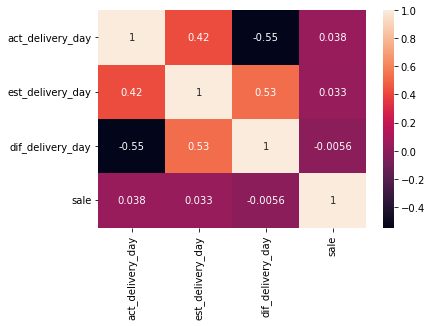

In [15]:
# add 2 columns which is actual and estimated delivery days (in unit of day)
# actual delivery days= order_delivered_customer_date - order_purchase_timestamp
# estimated delivery days= order_estimated_delivery_date - order_purchase_timestamp
a= olist["order_purchase_timestamp"]
b= olist["order_delivered_customer_date"]
c= olist["order_estimated_delivery_date"]
olist["act_delivery_day"]= (b-a).dt.days
olist["est_delivery_day"]= (c-a).dt.days
olist.head(3)

# Percentage of delivery before Estimated date
olist["dif_delivery_day"]= olist["est_delivery_day"]-olist["act_delivery_day"]
print("Percentage of delivery before Estimated date", (olist["dif_delivery_day"]>0).sum()/olist.shape[0])

delivery_and_sale= olist.loc[:, ["product_id","order_id", "act_delivery_day", "est_delivery_day",
                                         "dif_delivery_day","sale"]]
delivery_and_sale= delivery_and_sale.groupby("product_id").agg({"act_delivery_day":"mean","est_delivery_day":"mean",
                                             "dif_delivery_day":"mean","sale":"sum"})
print(delivery_and_sale.head(20))

sns.heatmap(delivery_and_sale.corr(), annot=True);

no significant relationship between delivery date and sale

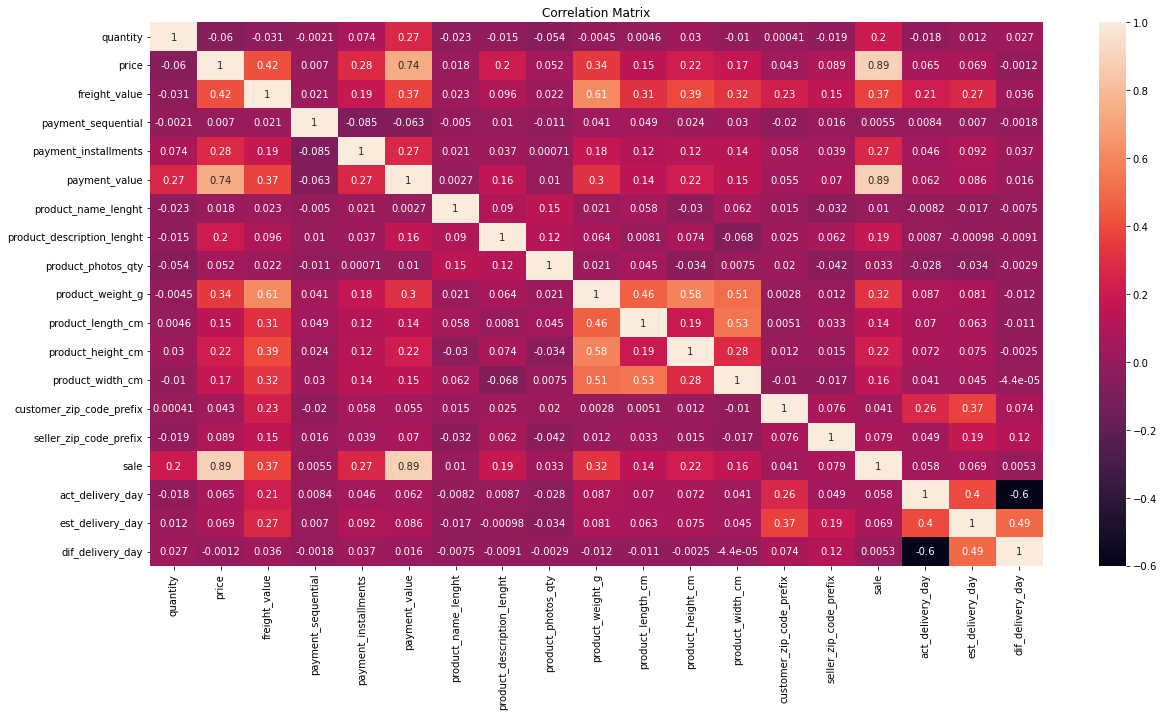

In [16]:
correlation_matrix = olist.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correlation_matrix, annot = True)
plt.title('Correlation Matrix')
plt.show()

Looking at the correlation matrix, there appears to be strong correlation between (payment value and price - which leads to sale)

# Data Regularization

In [36]:
#separating target variable

y = olist['price']
X = olist[['quantity', 'freight_value', 'payment_sequential', 'payment_installments',
             'payment_value']]

#splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
print(linear_model.score(X_test, y_test))

0.6689905370723275


In [37]:
# List to maintain the different cross-validation scores
cross_val_scores_ridge = []
 
# List to maintain the different values of alpha
alpha = []
 
# Loop to compute the different values of cross-validation scores
for i in range(1, 10):
    ridgeModel = Ridge(alpha = i * .75)
    ridgeModel.fit(X_train, y_train)
    scores = cross_val_score(ridgeModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(i * .75)
 
# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_ridge[i]))


0.75 : 47.914171176230425
1.5 : 47.91427365627946
2.25 : 47.914376123838665
3.0 : 47.91447857890908
3.75 : 47.914581021491784
4.5 : 47.914683451587806
5.25 : 47.91478586919825
6.0 : 47.91488827432413
6.75 : 47.91499066696654


We see that the best alpha value is 6.75

In [38]:
# Building and fitting the Ridge Regression model / l2
ridge_model = Ridge(alpha = 6.75)
ridge_model.fit(X_train, y_train)
 
# Evaluating the Ridge Regression model / l2
print(ridge_model.score(X_test, y_test))

0.6689891695808532


In [39]:
#lasso regression / l1
cross_val_scores_lasso = []
 
# initialize list
Lambda = []
 
# compute the cross-validation scores
for i in range(1, 20):
    lassoModel = Lasso(alpha = i * 0.25, tol = 0.0925)
    lassoModel.fit(X_train, y_train)
    scores = cross_val_score(lassoModel, X, y, cv = 10)
    avg_cross_val_score = mean(scores)*100
    cross_val_scores_lasso.append(avg_cross_val_score)
    Lambda.append(i * 0.25)
 
# Loop to print the different values of cross-validation scores
for i in range(0, len(alpha)):
    print(str(alpha[i])+' : '+str(cross_val_scores_lasso[i]))

0.75 : 47.982621998465895
1.5 : 48.06978515182961
2.25 : 48.13074801822498
3.0 : 48.137856889217126
3.75 : 48.19235675196928
4.5 : 48.242186739849686
5.25 : 48.287346852858335
6.0 : 48.399050575522054
6.75 : 48.434566339845894


we see that an alpha value of 6.75 is best

In [40]:
# Building and fitting Lasso Regression Model / L1
lasso_model = Lasso(alpha = 6.75, tol = 0.0925)
lasso_model.fit(X_train, y_train)
 
# Evaluating the Lasso Regression model / L1
print(lasso_model.score(X_test, y_test))

0.6618291064410733


Comparing results

In [41]:
# Building the two lists 
models = ['Linear Regression', 'Ridge Regression', 'Lasso Regression']
scores = [linear_model.score(X_test, y_test),
         ridge_model.score(X_test, y_test),
         lasso_model.score(X_test, y_test)]
 
# score comparison dictionary
mapping = {}
mapping['Linear Model'] = linear_model.score(X_test, y_test)
mapping['Ridge Regularization'] = ridge_model.score(X_test, y_test)
mapping['Lasso Regularization'] = lasso_model.score(X_test, y_test)
 
# printing scores for all models
for key, val in mapping.items():
    print(str(key)+' : '+str(val))

Linear Model : 0.6689905370723275
Ridge Regularization : 0.6689891695808532
Lasso Regularization : 0.6618291064410733


We conclude that L2 regularization, also known as Ridge regression, improved our data.

# PCA
#Changing categorical value to numerical values

In [20]:
olist_cat = ["order_status", "customer_state", "payment_type"] #categorical data

olist_num = ["quantity", "price", "freight_value", "payment_sequential", "payment_installments",
             "payment_value", "sale", "act_delivery_day", "est_delivery_day","dif_delivery_day","sale"]

pipeline = ColumnTransformer([('num', StandardScaler(), olist_num),('cat', OneHotEncoder(), olist_cat)])
olist_change = pipeline.fit_transform(olist)
olist_change.shape

(115878, 49)

In [21]:
olist_change = olist_change.toarray()  #changing to numpy array to perform pca because input cannot be sparse for pca

In [22]:
from sklearn.decomposition import PCA

# Preserving 95% of the variance
pca = PCA(n_components=0.95)
olist_reduced = pca.fit_transform(olist_change)
olist_reduced.shape

(115878, 11)